In [1]:
# define and move to dataset directory
import os
# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from datetime import datetime
from keras.optimizers import Adam
from keras.applications import ResNet50
from keras.layers import Input, AveragePooling2D
from keras.models import Model
import itertools 
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
trainPath = 'C:\\Users\\sazid\\Desktop\\data\\lizard_background_CNN\\train'
valPath = 'C:\\Users\\sazid\\Desktop\\data\\lizard_background_CNN\\valid'
testPath = 'C:\\Users\\sazid\\Desktop\\data\\lizard_background_CNN\\test'

In [3]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
testAug=ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean
testAug.mean = mean

In [4]:
# initialize the training generator
batch_size = 32
trainGen = trainAug.flow_from_directory(
    trainPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size)
# initialize the validation generator
valGen = valAug.flow_from_directory(
    valPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)
# initialize the testing generator
testGen = testAug.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size)

Found 2500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [5]:
## load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers[:168]:
    layer.trainable = False
for layer in baseModel.layers[168:]:
    layer.trainable=True

model.summary() 

# Make sure you have frozen the correct layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable

totalTrain=2500
totalVal=500
epochs=100
print("compiling model...")
learning_rate=1e-4
opt = Adam(lr=learning_rate, decay=learning_rate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["acc"])
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("training head...")
H = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // batch_size,
    validation_data=valGen,
    validation_steps=totalVal // batch_size,
    epochs=epochs)

compiling model...
training head...
Epoch 1/100
78/78 [==============================] - 130s 2s/step - loss: 0.7319 - acc: 0.6064 - val_loss: 0.5076 - val_acc: 0.7437
Epoch 2/100
78/78 [==============================] - 112s 1s/step - loss: 0.4814 - acc: 0.7615 - val_loss: 0.4284 - val_acc: 0.7750
Epoch 3/100
78/78 [==============================] - 113s 1s/step - loss: 0.4216 - acc: 0.8069 - val_loss: 0.4181 - val_acc: 0.7937
Epoch 4/100
78/78 [==============================] - 113s 1s/step - loss: 0.3883 - acc: 0.8205 - val_loss: 0.4407 - val_acc: 0.8104
Epoch 5/100
78/78 [==============================] - 112s 1s/step - loss: 0.3568 - acc: 0.8280 - val_loss: 0.4269 - val_acc: 0.8125
Epoch 6/100
78/78 [==============================] - 112s 1s/step - loss: 0.3456 - acc: 0.8472 - val_loss: 0.4341 - val_acc: 0.8083
Epoch 7/100
78/78 [==============================] - 111s 1s/step - loss: 0.3308 - acc: 0.8478 - val_loss: 0.4114 - val_acc: 0.8438
Epoch 8/100
78/78 [=====================

In [7]:
model.save("lizard_resnet_finetune.h5")

In [8]:
target_names = []
for key in trainGen.class_indices:
    target_names.append(key)
    
print(target_names)


['background', 'lizard']


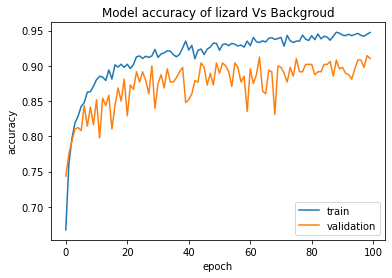

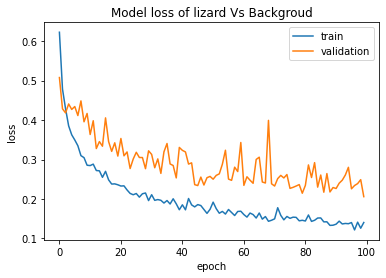

In [9]:
############################################
#Plot the Graph

acc = H.history['acc']
val_acc = H.history['val_acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)

# Accuracy Curves

plt.figure(1)
# summarize history for accuracy
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'])
plt.title('Model accuracy of lizard Vs Backgroud')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('acc1.png')
plt.show()

plt.figure(2)
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss of lizard Vs Backgroud')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.savefig('loss1.png')
plt.show()

In [10]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("evaluating after fine-tuning network head...")

totalTest=200
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(totalTest // batch_size) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
    target_names=testGen.class_indices.keys()))

evaluating after fine-tuning network head...
              precision    recall  f1-score   support

  background       0.90      0.73      0.81       100
      lizard       0.77      0.92      0.84       100

    accuracy                           0.82       200
   macro avg       0.84      0.82      0.82       200
weighted avg       0.84      0.82      0.82       200



Confusion matrix, without normalization


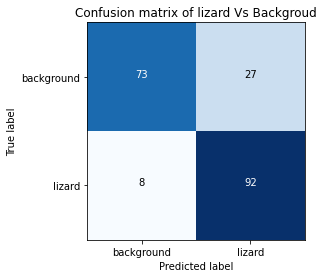

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix of lizard Vs background', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   

#thresh = cm.max() / 2.
#Matplotlib’s matshow
cm = confusion_matrix(testGen.classes, predIdxs)

plt.figure(3)
plot_confusion_matrix(cm, target_names, title='Confusion matrix of lizard Vs Backgroud')
#print(cm)
plt.savefig('lizard_resnet.png')
plt.show()